
**Install requirements**

In [1]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import models and utils from GitHub**

In [2]:
import os

if not os.path.isdir('./models'):
  !git clone https://github.com/alessandrodesole/Domain-adaptation-on-PACS-dataset.git
  !cp -r "/content/Domain-adaptation-on-PACS-dataset/Code/Models" "/content/"
  !cp -r "/content/Domain-adaptation-on-PACS-dataset/Code/Utils" "/content/"

Cloning into 'Domain-adaptation-on-PACS-dataset'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 38 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


**Import dataset from github**

In [3]:
# Clone github repository with data
import os

if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS


Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 40.12 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.


**Import libraries**

In [4]:
import os
import sys
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, ConcatDataset
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import copy

from models.AlexNetDANN import alexnet
from Utils.utils import *

**Set Arguments**

In [12]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7      # 7 classes for each domain

BATCH_SIZE = 64     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-4            # The initial Learning Rate
FIX_LR = True
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
ALPHA = 0.5
FIX_ALPHA = True

LOG_FREQUENCY = 10

# OPTIONS -----------------

KL = False
CHECK_CLASSES = True
COMPUTE_MEANS = False
COMPUTE_DISTRIBUTION = False
PLOT_DISTRIBUTION = False
IMAGE_SHOW = False
TRAIN_1 = False
TRAIN_2 = False
TRAIN_DANN = False
VALIDATION = False
VALIDATION_DANN = True
TEST_WITHOUT_DANN = True
TEST_WITH_DANN = True

CARTOON = False
SKETCH = True

**Define Data Preprocessing**

In [6]:
# Define transforms for training phase
train_transform = transforms.Compose([#transforms.Resize(227),      # Resizes short size of the PIL image to 227
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      #transforms.Normalize((0.5085, 0.4832, 0.4396), 0.2776, 0.2693, 0.2867)
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([#transforms.Resize(227),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    #transforms.Normalize((0.5085, 0.4832, 0.4396), 0.2776, 0.2693, 0.2867)                                    
])

**Prepare Dataset**

In [7]:
# All domains analysis

DOMAIN_DATA_DIR = 'Homework3-PACS/PACS'

# Prepare Pytorch train/test Datasets
domains_dataset = torchvision.datasets.ImageFolder(DOMAIN_DATA_DIR, transform=train_transform)

domains = domains_dataset.classes
domains_to_idx = domains_dataset.class_to_idx

# Check dataset size
print('Dataset: {}'.format(len(domains_dataset)))

Dataset: 9991


In [8]:
# All classes analysis

DATA_DIRs = []
DATA_DIRs.append('Homework3-PACS/PACS/art_painting')
DATA_DIRs.append('Homework3-PACS/PACS/cartoon')
DATA_DIRs.append('Homework3-PACS/PACS/photo')
DATA_DIRs.append('Homework3-PACS/PACS/sketch')

class_datasets = []

for d in DATA_DIRs:
  class_datasets.append(torchvision.datasets.ImageFolder(d, transform=train_transform))

classes = class_datasets[0].classes
class_to_idx = class_datasets[0].class_to_idx

class_dataset = ConcatDataset(class_datasets)

# Check dataset sizes
print('Dataset: {}'.format(len(class_dataset)))

Dataset: 9991


In [9]:
TRAIN_DATA_DIR = 'Homework3-PACS/PACS/photo'
TEST_DATA_DIR = 'Homework3-PACS/PACS/art_painting'

if VALIDATION or VALIDATION_DANN:
  if CARTOON:
    VAL_DATA_DIR = 'Homework3-PACS/PACS/cartoon'

  if SKETCH:
    VAL_DATA_DIR = 'Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Datasets
train_dataset = torchvision.datasets.ImageFolder(TRAIN_DATA_DIR, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(TEST_DATA_DIR, transform=eval_transform)

if VALIDATION or VALIDATION_DANN:
  val_dataset = torchvision.datasets.ImageFolder(VAL_DATA_DIR, transform=train_transform)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

if VALIDATION or VALIDATION_DANN:
  print('Validation Dataset: {}'.format(len(val_dataset)))

Train Dataset: 1670
Test Dataset: 2048
Validation Dataset: 3929


In [14]:
# Check if classes are distributed equally between training and test set

if CHECK_CLASSES:
  if VALIDATION or VALIDATION_DANN:
    check_classes(train_dataset, test_dataset, val_dataset)
  else:
    check_classes(train_dataset, test_dataset)

0    189
1    202
2    182
3    186
4    199
5    280
6    432
dtype: int64
0    379
1    255
2    285
3    184
4    201
5    295
6    449
dtype: int64
0    772
2    753
4    816
6    160
1    740
3    608
5     80
dtype: int64


 **Kullback-Leibler divergence**

In [ ]:
if KL:
  compute_kl(train_dataset, test_dataset)


**Compute means**

In [ ]:
if COMPUTE_MEANS:

  compute_means(train_dataset)

**Images distribution among domains/classes**

In [ ]:
if COMPUTE_DISTRIBUTION:

  compute_plot_distribution(classes, domains, train_dataset, test_dataset, val_dataset=None, class_dataset, domains_dataset)

**Visualize few images**

In [ ]:
# I want to print one image per class from training set

if IMAGE_SHOW:

  visited_class = set()
  # Get a batch of training data
  for inputs, d in domains_dataset:
    if d not in visited_class:
      # Make a grid from batch
      out = torchvision.utils.make_grid(inputs)
      imshow(out, title=domains[d])
      visited_class.add(d)

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)

if VALIDATION or VALIDATION_DANN:
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)

**Prepare Network**

In [ ]:
net = alexnet(pretrained=True, num_classes=NUM_CLASSES) # Loading AlexNet model

# Copy pretrained weights from the class classifier to the domain_classifier
net.domain_classifier[1].weight.data = net.class_classifier[1].weight.data
net.domain_classifier[1].bias.data = net.class_classifier[1].bias.data
net.domain_classifier[4].weight.data = net.class_classifier[4].weight.data
net.domain_classifier[4].bias.data = net.class_classifier[4].bias.data
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
net.domain_classifier[6] = nn.Linear(4096, 2)
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
if FIX_LR:
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
else:
  optimizer = optim.SGD(parameters_to_optimize, lr=1., momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

#for p in net.parameters():
#  p.requires_grad = True

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs

if FIX_LR:
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
else:
  lambda1 = lambda epoch: 0.01 / ((1 + 10 * (epoch / NUM_EPOCHS)) ** 0.75)
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda1)

**Train**

In [ ]:
if TRAIN_1:

  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  train_losses = []

  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    running_loss = 0.0
    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1
      running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / float(len(train_dataloader)*BATCH_SIZE)
    print("Train epoch loss: {}".format(epoch_loss))
    train_losses.append(loss)

    # Step the scheduler
    scheduler.step() 

In [ ]:
if TRAIN_2:

  since = time.time()

  print("Current Hyperparameters:")
  print(f"Epochs = {NUM_EPOCHS}")
  print(f"  Scheduler:")
  print(f"  - Step Size = {STEP_SIZE}")
  print(f"  - Gamma = {GAMMA}")
  print(f"Optimizer: {optimizer}")
  print(f"Device: {DEVICE}")
  print()

  train_loss = []
  train_acc = []

  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    net.train() # Sets module in training mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      with torch.set_grad_enabled(True):

        # Forward pass to the network
        outputs = net(images)

        _, preds = torch.max(outputs.data, 1)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients
        
      current_step += 1

      # statistics
      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data).data.item() 
    
    epoch_loss = running_loss / float(len(train_dataloader)*BATCH_SIZE)
    epoch_acc = running_corrects / float(len(train_dataloader)*BATCH_SIZE)

    train_loss.append(epoch_loss) # loss computed as the average on mini-batches
    #train_loss.append(loss) # loss computed only on the last batch
    train_acc.append(epoch_acc)

    print('Train -> Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # Step the scheduler
    scheduler.step()

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

**DANN Train**

In [ ]:
if TRAIN_DANN:

  since = time.time()

  print("Current Hyperparameters:")
  print(f"Epochs = {NUM_EPOCHS}")
  print(f"  Scheduler:")
  print(f"  - Step Size = {STEP_SIZE}")
  print(f"  - Gamma = {GAMMA}")
  print(f"Optimizer: {optimizer}")
  print(f"Device: {DEVICE}")
  print(f"Alpha: {ALPHA}")
  print()

  train_class_losses = []
  train_domain_losses = []
  test_domain_losses = []
  train_acc = []

  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    len_dataloader = min(len(train_dataloader), len(test_dataloader))
    data_train_iter = iter(train_dataloader)
    data_test_iter = iter(test_dataloader)

    running_train_class_losses = 0
    running_train_domain_losses = 0
    running_test_domain_losses = 0

    net.train()

    i = 0

    while i < len_dataloader:

      if FIX_ALPHA == False:
        p = float(i + epoch * len_dataloader) / NUM_EPOCHS / len_dataloader
        ALPHA = 2. / (1. + np.exp(-10 * p)) - 1
        print("Alpha = {}\n".format(ALPHA))

      # training model using source data
      data_train = data_train_iter.next()
      train_img, train_label = data_train

      #net.zero_grad()
      optimizer.zero_grad()
      batch_size = len(train_label)

      input_img = torch.FloatTensor(batch_size, 3, 224, 224)
      class_label = torch.LongTensor(batch_size)
      domain_label = torch.zeros(batch_size)
      domain_label = domain_label.long()

      train_img = train_img.to(DEVICE)
      train_label = train_label.to(DEVICE)
      input_img = input_img.to(DEVICE)
      class_label = class_label.to(DEVICE)
      domain_label = domain_label.to(DEVICE)

      input_img.resize_as_(train_img).copy_(train_img)
      class_label.resize_as_(train_label).copy_(train_label)

      train_class_output = net(input_img)
      train_class_loss = criterion(train_class_output, class_label)

      running_train_class_losses += train_class_loss.item() * train_img.size(0)

      # Compute gradients for each layer and update weights
      train_class_loss.backward()  # backward pass: computes gradients

      train_domain_output = net(input_img, alpha=ALPHA)
      train_domain_loss = criterion(train_domain_output, domain_label)

      running_train_domain_losses += train_domain_loss.item() * train_img.size(0)

      # Compute gradients for each layer and update weights
      train_domain_loss.backward()  # backward pass: computes gradients

      # training model using test data
      data_test = data_test_iter.next()
      test_img, _ = data_test

      batch_size = len(test_img)

      input_img = torch.FloatTensor(batch_size, 3, 224, 224)
      domain_label = torch.ones(batch_size)
      domain_label = domain_label.long()

      test_img =  test_img.to(DEVICE)
      input_img = input_img.to(DEVICE)
      domain_label = domain_label.to(DEVICE)

      input_img.resize_as_(test_img).copy_(test_img)

      test_domain_output = net(input_img, alpha=ALPHA)
      test_domain_loss = criterion(test_domain_output, domain_label)

      running_test_domain_losses += test_domain_loss.item() * test_img.size(0)

      # Compute gradients for each layer and update weights
      test_domain_loss.backward()  # backward pass: computes gradients

      #err = train_class_loss + train_domain_loss + test_domain_loss
      #err.backward()
      optimizer.step()

      i += 1

      print ('epoch: %d, [iter: %d / all %d], train_class_loss: %f, train_domain_loss: %f, test_domain_loss: %f' \
                % (epoch, i, len_dataloader, train_class_loss.data.cpu().numpy(),
                  train_domain_loss.data.cpu().numpy(), test_domain_loss.data.cpu().item()))
    

    epoch_train_class_loss = running_train_class_losses / float(len_dataloader * BATCH_SIZE)
    epoch_train_domain_loss = running_train_domain_losses / float(len_dataloader * BATCH_SIZE)
    epoch_test_domain_loss = running_test_domain_losses / float(len_dataloader * BATCH_SIZE)

    train_class_losses.append(epoch_train_class_loss)
    train_domain_losses.append(epoch_train_domain_loss)
    test_domain_losses.append(epoch_test_domain_loss)

    print("Train class loss: {}".format(epoch_train_class_loss))
    print("Train domain loss: {}".format(epoch_train_domain_loss))
    print("Test domain loss: {}".format(epoch_test_domain_loss))

    #Step the scheduler
    scheduler.step()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

**Validation**

In [ ]:
if VALIDATION:

  since = time.time()

  print("Current Hyperparameters:")
  print(f"Epochs = {NUM_EPOCHS}")
  print(f"  Scheduler:")
  print(f"  - Step Size = {STEP_SIZE}")
  print(f"  - Gamma = {GAMMA}")
  print(f"Optimizer: {optimizer}")
  print(f"Device: {DEVICE}")
  print()

  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    net.train() # Sets module in training mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      with torch.set_grad_enabled(True):

        # Forward pass to the network
        outputs = net(images)

        _, preds = torch.max(outputs, 1)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients
        
      current_step += 1

      # statistics
      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data).data.item() 
    
    epoch_loss = running_loss / float(len(train_dataloader)*BATCH_SIZE)
    epoch_acc = running_corrects / float(len(train_dataloader)*BATCH_SIZE)

    train_loss.append(epoch_loss) # loss computed as the average on mini-batches
    #train_loss.append(loss) # loss computed only on the last batch
    train_acc.append(epoch_acc)

    print('Train -> Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    ### Start Validation phase

    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_val_loss = 0.0
    running_val_corrects = 0

    for images, labels in val_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # zero the parameter gradients
      #optimizer.zero_grad()

      with torch.set_grad_enabled(False):

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs, 1)

        # Update Corrects
        #running_corrects += torch.sum(preds == labels.data).data.item()

        # Calculate Loss
        loss = criterion(outputs.data, labels)

      # Update Corrects and Loss
      running_val_loss += loss.item() * images.size(0)
      running_val_corrects += torch.sum(preds == labels.data).data.item()

    epoch_val_loss = running_val_loss / float(len(val_dataset))
    epoch_val_acc = running_val_corrects / float(len(val_dataset))

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    print('Validation -> Loss: {:.4f} Acc: {:.4f}'.format(epoch_val_loss, epoch_val_acc))

    # Calculate Accuracy
    accuracy = running_val_corrects / float(len(val_dataset))

    print('Validation Accuracy: {}'.format(accuracy))

    # Step the scheduler
    scheduler.step()

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


**Validation DANN**

In [ ]:
#net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
#net.train(False) # Set Network to evaluation mode

def test(dataloader, epoch, net, train):

  net = net.to(DEVICE)

  net.eval() # Set Network to evaluation mode

  len_dataloader = len(dataloader)
  data_test_iter = iter(dataloader)

  i = 0
  running_corrects = 0
  running_loss = 0.0
  total_dim = 0

  while i < len_dataloader:

   # test model using target data
    data_test = data_test_iter.next()
    test_img, test_label = data_test

    batch_size = len(test_label)

    input_img = torch.FloatTensor(batch_size, 3, 224, 224)
    class_label = torch.LongTensor(batch_size)

    test_img = test_img.to(DEVICE)
    test_label = test_label.to(DEVICE)
    input_img = input_img.to(DEVICE)
    class_label = class_label.to(DEVICE)

    input_img.resize_as_(test_img).copy_(test_img)
    class_label.resize_as_(test_label).copy_(test_label)

    class_output = net(input_img)
    loss = criterion(class_output, class_label)
    pred = class_output.data.max(1, keepdim=True)[1]
    #_, pred = torch.max(class_output.data, 1)
    #running_corrects += torch.sum(pred == class_label.data).data.item()
    running_loss += loss.item() * test_img.size(0)
    running_corrects += pred.eq(class_label.data.view_as(pred)).cpu().sum()
    total_dim += batch_size

    i += 1

  accuracy = running_corrects.data.numpy() * 1.0 / total_dim
  final_loss = running_loss / float(total_dim)
  #accuracy = running_corrects / float(len(test_dataset))
  
  if train == 1:
    print('Validation Accuracy: {}'.format(accuracy))
    print('Validation Loss: {}'.format(final_loss))
    print('epoch: %d, accuracy on the validation dataset: %f' % (epoch, accuracy))
    print('epoch: %d, loss on the validation dataset: %f' % (epoch, final_loss))
  else:
    print('Training Accuracy: {}'.format(accuracy))
    print('Training Loss: {}'.format(final_loss))
    print('epoch: %d, accuracy on the training dataset: %f' % (epoch, accuracy))
    print('epoch: %d, loss on the training dataset: %f' % (epoch, final_loss))
  

  return accuracy, final_loss

In [ ]:
if VALIDATION_DANN:

  since = time.time()

  print("Current Hyperparameters:")
  print(f"Epochs = {NUM_EPOCHS}")
  print(f"  Scheduler:")
  print(f"  - Step Size = {STEP_SIZE}")
  print(f"  - Gamma = {GAMMA}")
  print(f"Optimizer: {optimizer}")
  print(f"Device: {DEVICE}")
  print(f"Alpha: {ALPHA}")
  print()

  train_class_losses = []
  train_domain_losses = []
  val_domain_losses = []
  train_acc = []
  val_acc = []
  train_loss = []
  val_loss = []
  tot_losses = []

  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    len_dataloader = min(len(train_dataloader), len(val_dataloader))
    data_train_iter = iter(train_dataloader)
    data_val_iter = iter(val_dataloader)

    running_train_class_losses = 0
    running_train_domain_losses = 0
    running_val_domain_losses = 0
    running_tot_loss = 0

    net.train()

    i = 0

    while i < len_dataloader:
      
      if FIX_ALPHA == False:
        p = float(i + epoch * len_dataloader) / NUM_EPOCHS / len_dataloader
        ALPHA = 2. / (1. + np.exp(-10 * p)) - 1
        print(ALPHA)

      # training model using source data
      data_train = data_train_iter.next()
      train_img, train_label = data_train

      #net.zero_grad()
      optimizer.zero_grad()
      batch_size = len(train_label)

      input_img = torch.FloatTensor(batch_size, 3, 224, 224)
      class_label = torch.LongTensor(batch_size)
      domain_label = torch.zeros(batch_size)
      domain_label = domain_label.long()

      train_img = train_img.to(DEVICE)
      train_label = train_label.to(DEVICE)
      input_img = input_img.to(DEVICE)
      class_label = class_label.to(DEVICE)
      domain_label = domain_label.to(DEVICE)

      input_img.resize_as_(train_img).copy_(train_img)
      class_label.resize_as_(train_label).copy_(train_label)

      train_class_output = net(input_img)
      train_class_loss = criterion(train_class_output, class_label)

      running_train_class_losses += train_class_loss.item() * train_img.size(0)

      # Compute gradients for each layer and update weights
      train_class_loss.backward()  # backward pass: computes gradients

      train_domain_output = net(input_img, alpha=ALPHA)
      train_domain_loss = criterion(train_domain_output, domain_label)

      running_train_domain_losses += train_domain_loss.item() * train_img.size(0)

      # Compute gradients for each layer and update weights
      train_domain_loss.backward()  # backward pass: computes gradients

      # training model using test data
      data_val = data_val_iter.next()
      val_img, _ = data_val

      batch_size = len(val_img)

      input_img = torch.FloatTensor(batch_size, 3, 224, 224)
      domain_label = torch.ones(batch_size)
      domain_label = domain_label.long()

      val_img =  val_img.to(DEVICE)
      input_img = input_img.to(DEVICE)
      domain_label = domain_label.to(DEVICE)

      input_img.resize_as_(val_img).copy_(val_img)

      val_domain_output = net(input_img, alpha=ALPHA)
      val_domain_loss = criterion(val_domain_output, domain_label)

      running_val_domain_losses += val_domain_loss.item() * val_img.size(0)

      # Compute gradients for each layer and update weights
      val_domain_loss.backward()  # backward pass: computes gradients

      running_tot_loss += train_class_loss.item() * train_img.size(0)
      running_tot_loss += train_domain_loss.item() * train_img.size(0)
      running_tot_loss += val_domain_loss.item() * train_img.size(0)
      #err.backward()
      optimizer.step()

      i += 1

      print ('epoch: %d, [iter: %d / all %d], train_class_loss: %f, train_domain_loss: %f, test_domain_loss: %f' \
                % (epoch, i, len_dataloader, train_class_loss.data.cpu().numpy(),
                  train_domain_loss.data.cpu().numpy(), val_domain_loss.data.cpu().item()))
    

    epoch_train_class_loss = running_train_class_losses / float(len_dataloader * BATCH_SIZE)
    epoch_train_domain_loss = running_train_domain_losses / float(len_dataloader * BATCH_SIZE)
    epoch_val_domain_loss = running_val_domain_losses / float(len_dataloader * BATCH_SIZE)
    epoch_tot_loss = running_tot_loss / float(len_dataloader * BATCH_SIZE)

    train_class_losses.append(epoch_train_class_loss)
    train_domain_losses.append(epoch_train_domain_loss)
    val_domain_losses.append(epoch_val_domain_loss)
    tot_losses.append(epoch_tot_loss)

    print("Train class loss: {}".format(epoch_train_class_loss))
    print("Train domain loss: {}".format(epoch_train_domain_loss))
    print("Val domain loss: {}".format(epoch_val_domain_loss))
    print("Total loss: {}".format(epoch_tot_loss))

    acc_t, loss_t = test(train_dataloader, epoch, net, 0)
    acc_v, loss_v = test(val_dataloader, epoch, net, 1)

    train_acc.append(acc_t)
    val_acc.append(acc_v)
    train_loss.append(loss_t)
    val_loss.append(loss_v)

    #Step the scheduler
    scheduler.step()

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


Current Hyperparameters:
Epochs = 30
  Scheduler:
  - Step Size = 20
  - Gamma = 0.1
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.0001
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 5e-05
)
Device: cuda
Alpha: 0.5

Starting epoch 1/30, LR = [0.0001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


epoch: 0, [iter: 1 / all 26], train_class_loss: 1.967592, train_domain_loss: 0.903551, test_domain_loss: 0.679992
epoch: 0, [iter: 2 / all 26], train_class_loss: 1.979210, train_domain_loss: 0.839771, test_domain_loss: 0.681546
epoch: 0, [iter: 3 / all 26], train_class_loss: 1.983134, train_domain_loss: 0.842197, test_domain_loss: 0.704661
epoch: 0, [iter: 4 / all 26], train_class_loss: 1.935264, train_domain_loss: 0.727685, test_domain_loss: 0.713260
epoch: 0, [iter: 5 / all 26], train_class_loss: 1.941480, train_domain_loss: 0.722029, test_domain_loss: 0.716929
epoch: 0, [iter: 6 / all 26], train_class_loss: 1.954481, train_domain_loss: 0.590642, test_domain_loss: 0.684076
epoch: 0, [iter: 7 / all 26], train_class_loss: 1.913856, train_domain_loss: 0.529760, test_domain_loss: 0.727649
epoch: 0, [iter: 8 / all 26], train_class_loss: 1.940026, train_domain_loss: 0.482370, test_domain_loss: 0.726601
epoch: 0, [iter: 9 / all 26], train_class_loss: 1.942278, train_domain_loss: 0.402101, t

**Visualization Function**

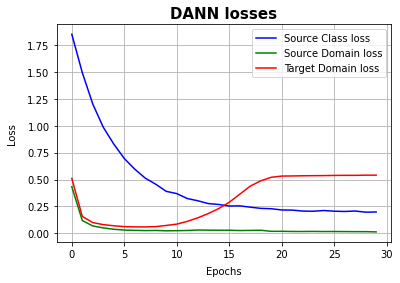

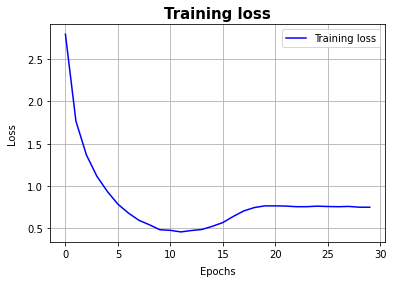

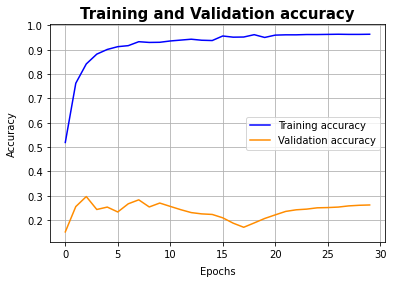

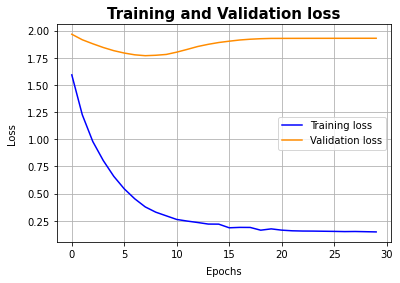

In [ ]:
if TRAIN_1:
  plot_loss(train_losses)

if TRAIN_2:
  plot_loss(train_loss)
  plot_accuracy(train_acc)

if TRAIN_DANN:
  plot_loss_DANN(train_class_losses, train_domain_losses, test_domain_losses)

if VALIDATION:
  plot_loss_val(train_loss, val_loss)
  plot_accuracy_val(train_acc, val_acc)

if VALIDATION_DANN:
  plot_loss_DANN(train_class_losses, train_domain_losses, val_domain_losses)
  plot_loss(tot_losses)
  plot_accuracy_val(train_acc, val_acc)
  plot_loss_val(train_loss, val_loss)

**Test**

In [ ]:
if TEST_WITHOUT_DANN:

  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  total = 0
  with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      total += labels.size(0)
      running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))
  accuracy_2 = running_corrects / float(total)

  print('Test Accuracy: {}'.format(accuracy))
  print('Test Accuracy: {}'.format(accuracy_2))

100%|██████████| 32/32 [00:05<00:00,  6.37it/s]

Test Accuracy: 0.5
Test Accuracy: 0.5


In [ ]:
if TEST_WITH_DANN:

  net = net.eval()
  net = net.to(DEVICE)

  len_dataloader = len(test_dataloader)
  data_test_iter = iter(test_dataloader)

  i = 0
  n_total = 0
  n_correct = 0

  while i < len_dataloader:

    # Test model using target data
    data_test = data_test_iter.next()
    test_img, test_label = data_test

    batch_size = len(test_label)

    input_img = torch.FloatTensor(batch_size, 3, 224, 224)
    class_label = torch.LongTensor(batch_size)

    test_img = test_img.to(DEVICE)
    test_label = test_label.to(DEVICE)
    input_img = input_img.to(DEVICE)
    class_label = class_label.to(DEVICE)

    input_img.resize_as_(test_img).copy_(test_img)
    class_label.resize_as_(test_label).copy_(test_label)

    class_output = net(input_img)
    
    pred = class_output.data.max(1, keepdim=True)[1]
    n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
    n_total += batch_size

    i+=1

  accuracy = n_correct.data.numpy() * 1.0 / n_total

  print('accuracy on Test dataset: {}'.format(accuracy))


accuracy on Test dataset: 0.5
